In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn
from tqdm import tqdm
import cv2 
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DIR = '/kaggle/input/yk-tourist-atrraction'

X = []
Z = []

LOC_HEHA_DIR = '/kaggle/input/yk-tourist-atrraction/HehaSkyView'
LOC_PARIS_DIR='/kaggle/input/yk-tourist-atrraction/parangtritis'
LOC_PRAMBANAN_DIR='/kaggle/input/yk-tourist-atrraction/prambanan'
LOC_TMPMNRH_DIR='/kaggle/input/yk-tourist-atrraction/tumpeng_monoreh' 


IMG_SIZE =150

In [3]:
def assign_label(img, loc_type):
    return loc_type

def make_train_data(loc_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,loc_type)
        path=os.path.join(DIR,img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        

In [4]:
make_train_data('HEHA',LOC_HEHA_DIR)
print(len(X))

100%|██████████| 416/416 [00:06<00:00, 63.27it/s]

416


In [5]:
make_train_data('PARIS',LOC_PARIS_DIR)
print(len(X))

100%|██████████| 420/420 [00:05<00:00, 73.07it/s]

836


In [6]:
make_train_data('PRAMBANAN',LOC_PRAMBANAN_DIR)
print(len(X))

100%|██████████| 440/440 [00:15<00:00, 27.68it/s]

1276


In [7]:
make_train_data('TMPMNRH',LOC_TMPMNRH_DIR)
print(len(X))

100%|██████████| 400/400 [00:05<00:00, 73.46it/s]

1676


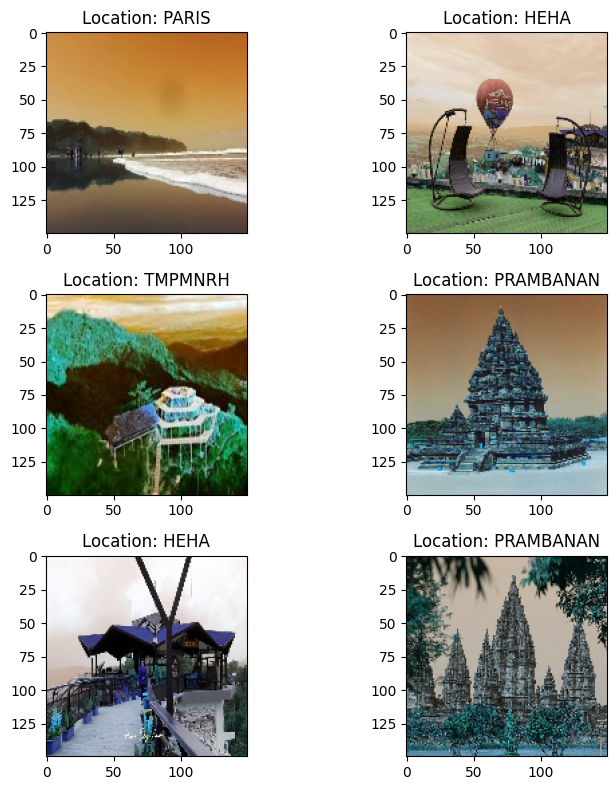

In [8]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(8,8)

for i in range(3):
    for j in range(2):
        l = np.random.randint(0, len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Location: ' + Z[l])
                       
plt.tight_layout()

In [9]:
le = LabelEncoder()
Y=le.fit_transform(Z)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'HEHA': 0, 'PARIS': 1, 'PRAMBANAN': 2, 'TMPMNRH': 3}


In [10]:
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [11]:
X_train,x_test, y_train, y_test=train_test_split(X,Y,test_size=0.60, random_state=42)

In [12]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [13]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))

In [14]:
batch_size=50
epochs=10
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening = False, 
    rotation_range=10, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip =True,
    vertical_flip = False) 

In [16]:
model.compile(optimizer=Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      2944      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 96)        0

In [18]:
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=len(X_train) // batch_size
)


/tmp/ipykernel_26/3910136754.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
13/13 [==============================] - 16s 380ms/step - loss: 1.6150 - accuracy: 0.2935 - val_loss: 1.2927 - val_accuracy: 0.3757
Epoch 2/10
13/13 [==============================] - 3s 266ms/step - loss: 1.1233 - accuracy: 0.5387 - val_loss: 1.2106 - val_accuracy: 0.4732
Epoch 3/10
13/13 [==============================] - 4s 269ms/step - loss: 0.9106 - accuracy: 0.6323 - val_loss: 0.9050 - val_accuracy: 0.6978
Epoch 4/10
13/13 [==============================] - 3s 262ms/step - loss: 0.8096 - accuracy: 0.6935 - val_loss: 0.8474 - val_accuracy: 0.7167
Epoch 5/10
13/13 [==============================] - 4s 270ms/step - loss: 0.7999 - accuracy: 0.6855 - val_loss: 0.8711 - val_accuracy: 0.7356
Epoch 6/10
13/13 [==============================] - 3s 261ms/step - loss: 0.6795 - accuracy: 0.7468 - val_loss: 1.0810 - val_accuracy: 0.6909
Epoch 7/10
13/13 [==============================] - 3s 263ms/step - loss: 0.6510 - accuracy: 0.7710 - val_loss: 1.0139 - val_accuracy: 0.7078
Epoch

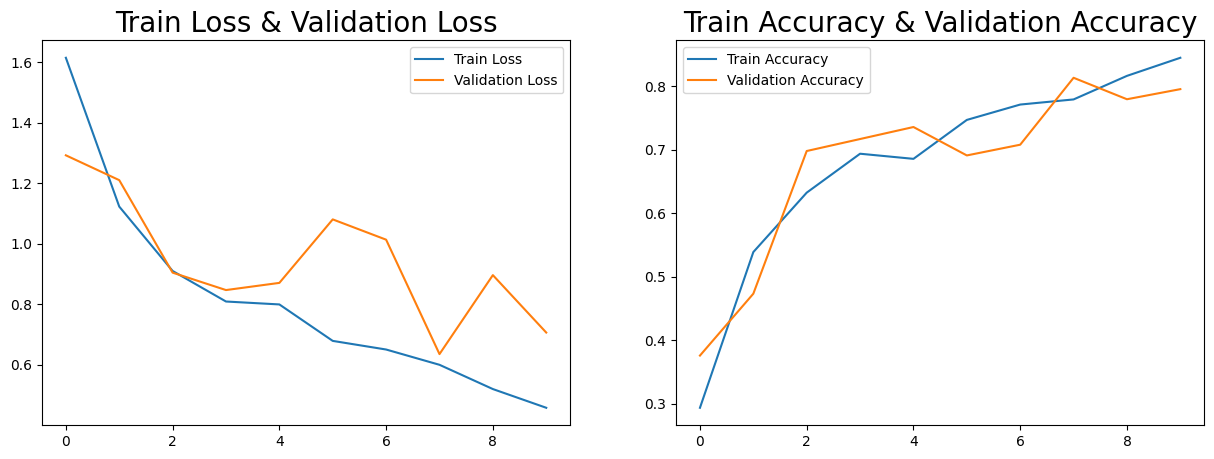

In [19]:
plt.figure(figsize=(15, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()

plt.show()


In [20]:
history=pd.DataFrame(history.history)
history

loss  accuracy  val_loss  val_accuracy
0  1.615007  0.293548  1.292699      0.375746
1  1.123299  0.538710  1.210643      0.473161
2  0.910560  0.632258  0.904994      0.697813
3  0.809589  0.693548  0.847422      0.716700
4  0.799948  0.685484  0.871145      0.735586
5  0.679456  0.746774  1.080954      0.690855
6  0.650960  0.770968  1.013943      0.707753
7  0.600451  0.779032  0.635814      0.813121
8  0.520304  0.816129  0.896805      0.779324
9  0.458441  0.844615  0.707023      0.795229

In [21]:
model.evaluate(X_train,y_train)

21/21 [==============================] - 1s 24ms/step - loss: 0.4836 - accuracy: 0.8478


[0.4836343228816986, 0.8477612137794495]

In [22]:
# Melakukan inferensi pada model untuk data uji
predictions = model.predict(x_test)

# Mencetak hasil prediksi untuk beberapa contoh
for i in range(6):  # Ganti angka 5 dengan jumlah contoh yang ingin Anda cek
    true_label = le.inverse_transform([np.argmax(y_test[i])])[0]
    predicted_label = le.inverse_transform([np.argmax(predictions[i])])[0]

    print(f"Example {i + 1} - True Label: {true_label}, Predicted Label: {predicted_label}")
    print("Prediction Scores:", predictions[i])
    print()


32/32 [==============================] - 0s 9ms/step
Example 1 - True Label: PRAMBANAN, Predicted Label: PRAMBANAN
Prediction Scores: [2.4242615e-03 3.0085717e-05 9.9103570e-01 6.5099471e-03 1.0085788e-09]

Example 2 - True Label: PRAMBANAN, Predicted Label: PRAMBANAN
Prediction Scores: [8.11178088e-02 2.00031023e-03 8.93918693e-01 2.29631830e-02
 1.15603406e-07]

Example 3 - True Label: PARIS, Predicted Label: TMPMNRH
Prediction Scores: [1.3827090e-02 4.5872933e-01 1.7775279e-02 5.0957251e-01 9.5787429e-05]

Example 4 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [3.1248558e-01 1.2030731e-07 3.7722424e-02 6.4979184e-01 6.6817775e-13]

Example 5 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [1.6634482e-03 1.0026280e-03 1.3727903e-01 8.6005449e-01 2.8207774e-07]

Example 6 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [6.8820350e-02 4.8123982e-02 2.9765297e-02 8.5306382e-01 2.2653758e-04]



Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.79       268
           1       0.95      0.69      0.80       250
           2       0.86      0.77      0.81       256
           3       0.73      0.86      0.79       232

    accuracy                           0.80      1006
   macro avg       0.81      0.80      0.80      1006
weighted avg       0.81      0.80      0.80      1006



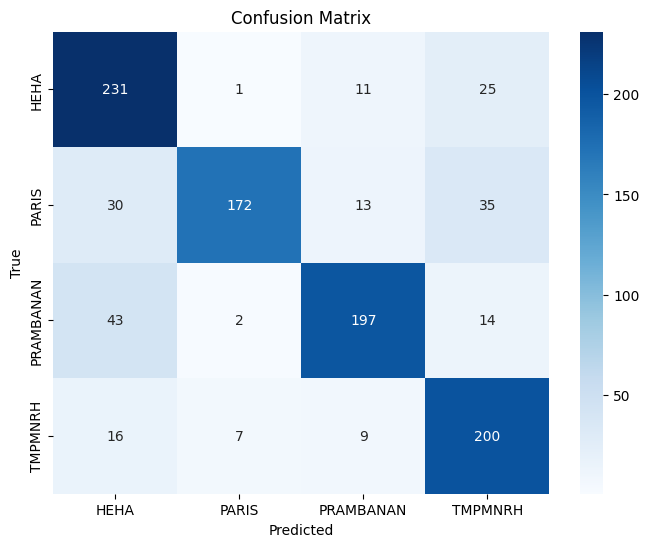

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [24]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-5 * 10 ** (epoch / 20))

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['acc'])

history = model.fit(x_test, y_test, epochs =10 , callbacks=[lr_schedule])


Epoch 1/10
32/32 [==============================] - 4s 41ms/step - loss: 1.0293 - acc: 0.8072 - lr: 1.0000e-05
Epoch 2/10
32/32 [==============================] - 1s 32ms/step - loss: 0.7566 - acc: 0.8250 - lr: 1.1220e-05
Epoch 3/10
32/32 [==============================] - 1s 32ms/step - loss: 0.6023 - acc: 0.8320 - lr: 1.2589e-05
Epoch 4/10
32/32 [==============================] - 1s 32ms/step - loss: 0.5106 - acc: 0.8330 - lr: 1.4125e-05
Epoch 5/10
32/32 [==============================] - 1s 32ms/step - loss: 0.4462 - acc: 0.8330 - lr: 1.5849e-05
Epoch 6/10
32/32 [==============================] - 1s 32ms/step - loss: 0.3915 - acc: 0.8410 - lr: 1.7783e-05
Epoch 7/10
32/32 [==============================] - 1s 33ms/step - loss: 0.3339 - acc: 0.8419 - lr: 1.9953e-05
Epoch 8/10
32/32 [==============================] - 1s 33ms/step - loss: 0.2703 - acc: 0.8529 - lr: 2.2387e-05
Epoch 9/10
32/32 [==============================] - 1s 32ms/step - loss: 0.2183 - acc: 0.8559 - lr: 2.5119e-05
E

(1e-05, 1.0, 0.0, 1.0)

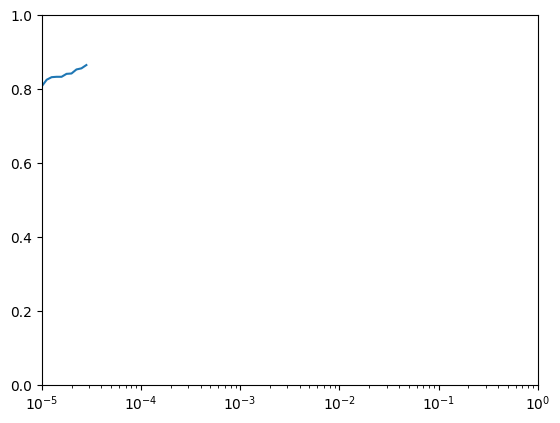

In [25]:
plt.semilogx(history.history["lr"], history.history["acc"])
plt.axis([1e-5, 1, 0, 1])

In [26]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-04),loss = 'binary_crossentropy',metrics = ['acc'])

model_retrain_with_tuning = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=100,
    validation_data=(x_test, y_test),
    verbose=1,
)

/tmp/ipykernel_26/2123219012.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_retrain_with_tuning = model.fit_generator(


Epoch 1/100
14/14 [==============================] - 6s 301ms/step - loss: 0.2170 - acc: 0.7896 - val_loss: 0.2100 - val_acc: 0.8300
Epoch 2/100
14/14 [==============================] - 4s 261ms/step - loss: 0.1846 - acc: 0.8343 - val_loss: 0.1891 - val_acc: 0.8479
Epoch 3/100
14/14 [==============================] - 4s 256ms/step - loss: 0.1688 - acc: 0.8433 - val_loss: 0.2072 - val_acc: 0.8250
Epoch 4/100
14/14 [==============================] - 4s 251ms/step - loss: 0.1570 - acc: 0.8507 - val_loss: 0.2351 - val_acc: 0.8012
Epoch 5/100
14/14 [==============================] - 4s 258ms/step - loss: 0.1560 - acc: 0.8567 - val_loss: 0.2267 - val_acc: 0.8151
Epoch 6/100
14/14 [==============================] - 4s 253ms/step - loss: 0.1472 - acc: 0.8836 - val_loss: 0.2229 - val_acc: 0.8320
Epoch 7/100
14/14 [==============================] - 4s 253ms/step - loss: 0.1395 - acc: 0.8687 - val_loss: 0.2189 - val_acc: 0.8260
Epoch 8/100
14/14 [==============================] - 4s 265ms/step - 

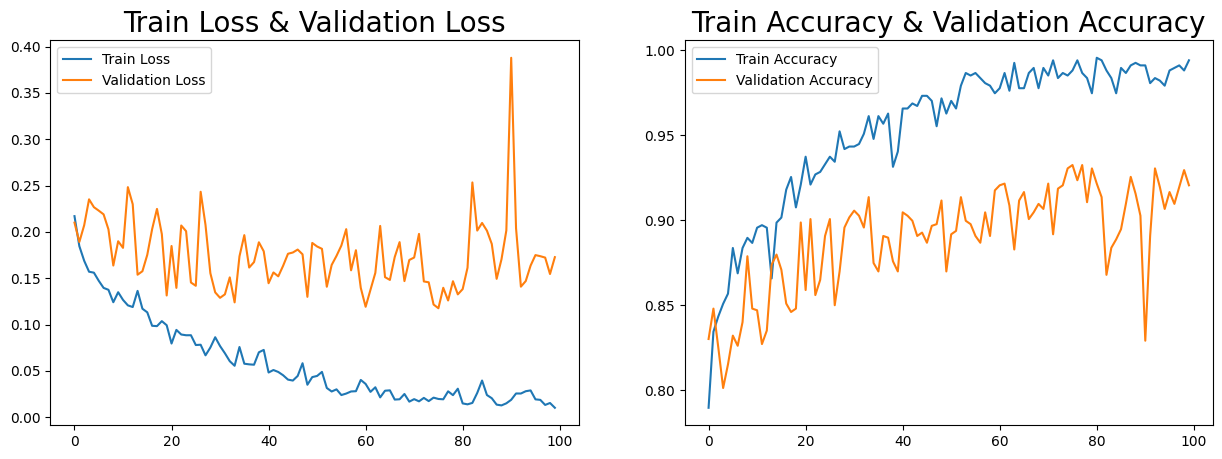

In [27]:
plt.figure(figsize=(15, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(model_retrain_with_tuning.history['loss'], label='Train Loss')
plt.plot(model_retrain_with_tuning.history['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_retrain_with_tuning.history['acc'], label='Train Accuracy')
plt.plot(model_retrain_with_tuning.history['val_acc'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()

plt.show()

In [28]:
model.evaluate(X_train,y_train)

21/21 [==============================] - 0s 13ms/step - loss: 0.0236 - acc: 0.9791


[0.02356931008398533, 0.9791044592857361]

In [29]:
# Melakukan inferensi pada model untuk data uji
predictions = model.predict(x_test)

# Mencetak hasil prediksi untuk beberapa contoh
for i in range(6):  
    true_label = le.inverse_transform([np.argmax(y_test[i])])[0]
    predicted_label = le.inverse_transform([np.argmax(predictions[i])])[0]

    print(f"Example {i + 1} - True Label: {true_label}, Predicted Label: {predicted_label}")
    print("Prediction Scores:", predictions[i])
    print()


32/32 [==============================] - 0s 11ms/step
Example 1 - True Label: PRAMBANAN, Predicted Label: PRAMBANAN
Prediction Scores: [5.9309483e-18 2.8694858e-18 1.0000000e+00 3.3727937e-20 2.0987242e-29]

Example 2 - True Label: PRAMBANAN, Predicted Label: PRAMBANAN
Prediction Scores: [4.6833050e-12 3.5844259e-18 1.0000000e+00 9.4527365e-21 1.6237473e-24]

Example 3 - True Label: PARIS, Predicted Label: PARIS
Prediction Scores: [1.6597766e-12 1.0000000e+00 1.5369951e-10 4.8843085e-10 9.2329728e-17]

Example 4 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [1.3847021e-07 1.3415760e-02 3.6507172e-05 9.8654765e-01 2.1827034e-18]

Example 5 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [2.3172944e-09 2.3813452e-06 1.1020687e-06 9.9999654e-01 3.8110517e-17]

Example 6 - True Label: TMPMNRH, Predicted Label: TMPMNRH
Prediction Scores: [4.5576915e-05 6.0113586e-02 4.7372794e-04 9.3936718e-01 1.7769937e-08]



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       268
           1       0.96      0.90      0.93       250
           2       0.89      0.98      0.94       256
           3       0.95      0.84      0.89       232

    accuracy                           0.92      1006
   macro avg       0.92      0.92      0.92      1006
weighted avg       0.92      0.92      0.92      1006



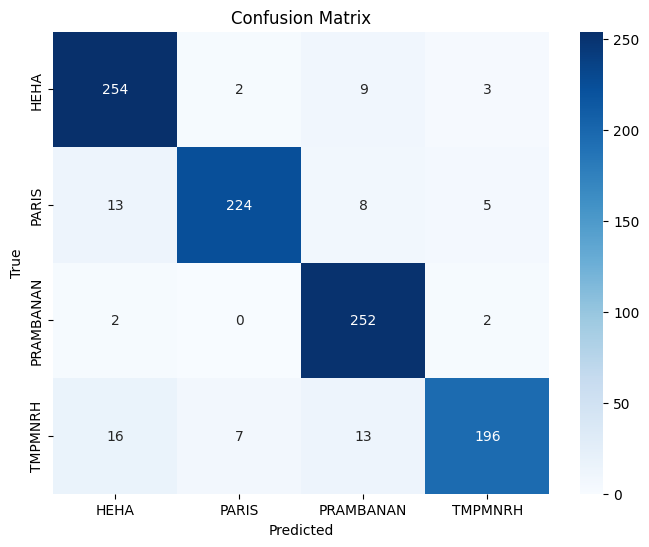

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

#Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       268
           1       0.96      0.90      0.93       250
           2       0.89      0.98      0.94       256
           3       0.95      0.84      0.89       232

    accuracy                           0.92      1006
   macro avg       0.92      0.92      0.92      1006
weighted avg       0.92      0.92      0.92      1006



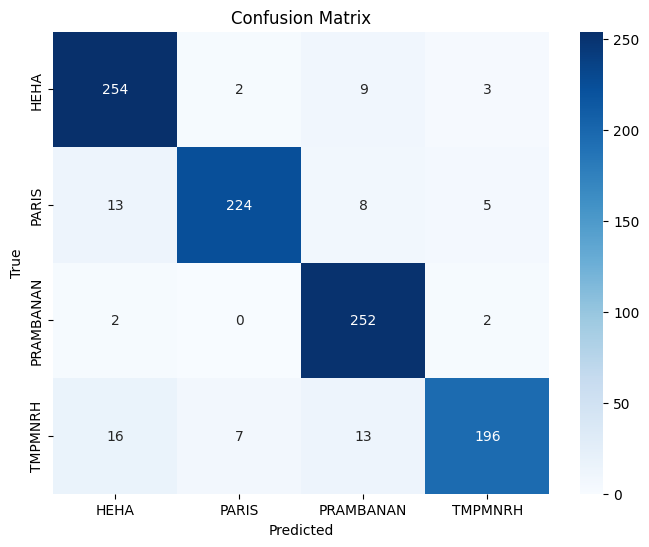

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

#Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [32]:
model.save('saved/model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
from tensorflow.keras.models import load_model
model=load_model('/kaggle/working/saved/model.h5')
predictions = model.predict(x_test)
best_preds = np.argmax(predictions, axis=1)

32/32 [==============================] - 0s 12ms/step


In [34]:
print(best_preds)

[2 2 1 ... 2 0 0]


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       268
           1       0.96      0.90      0.93       250
           2       0.89      0.98      0.94       256
           3       0.95      0.84      0.89       232

    accuracy                           0.92      1006
   macro avg       0.92      0.92      0.92      1006
weighted avg       0.92      0.92      0.92      1006



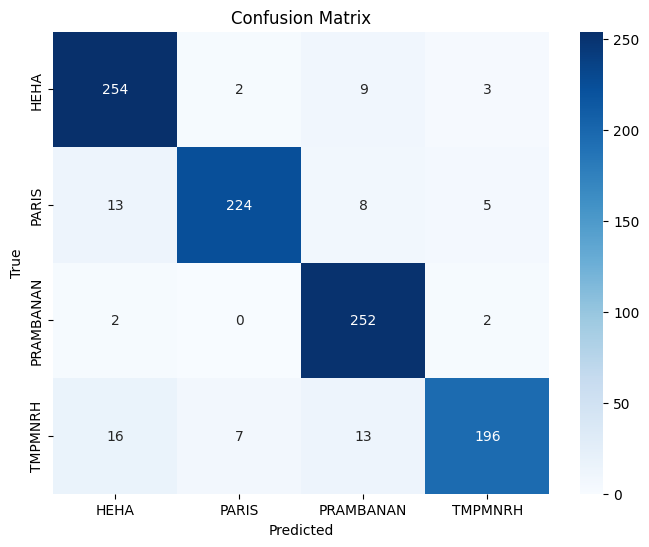

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

#Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


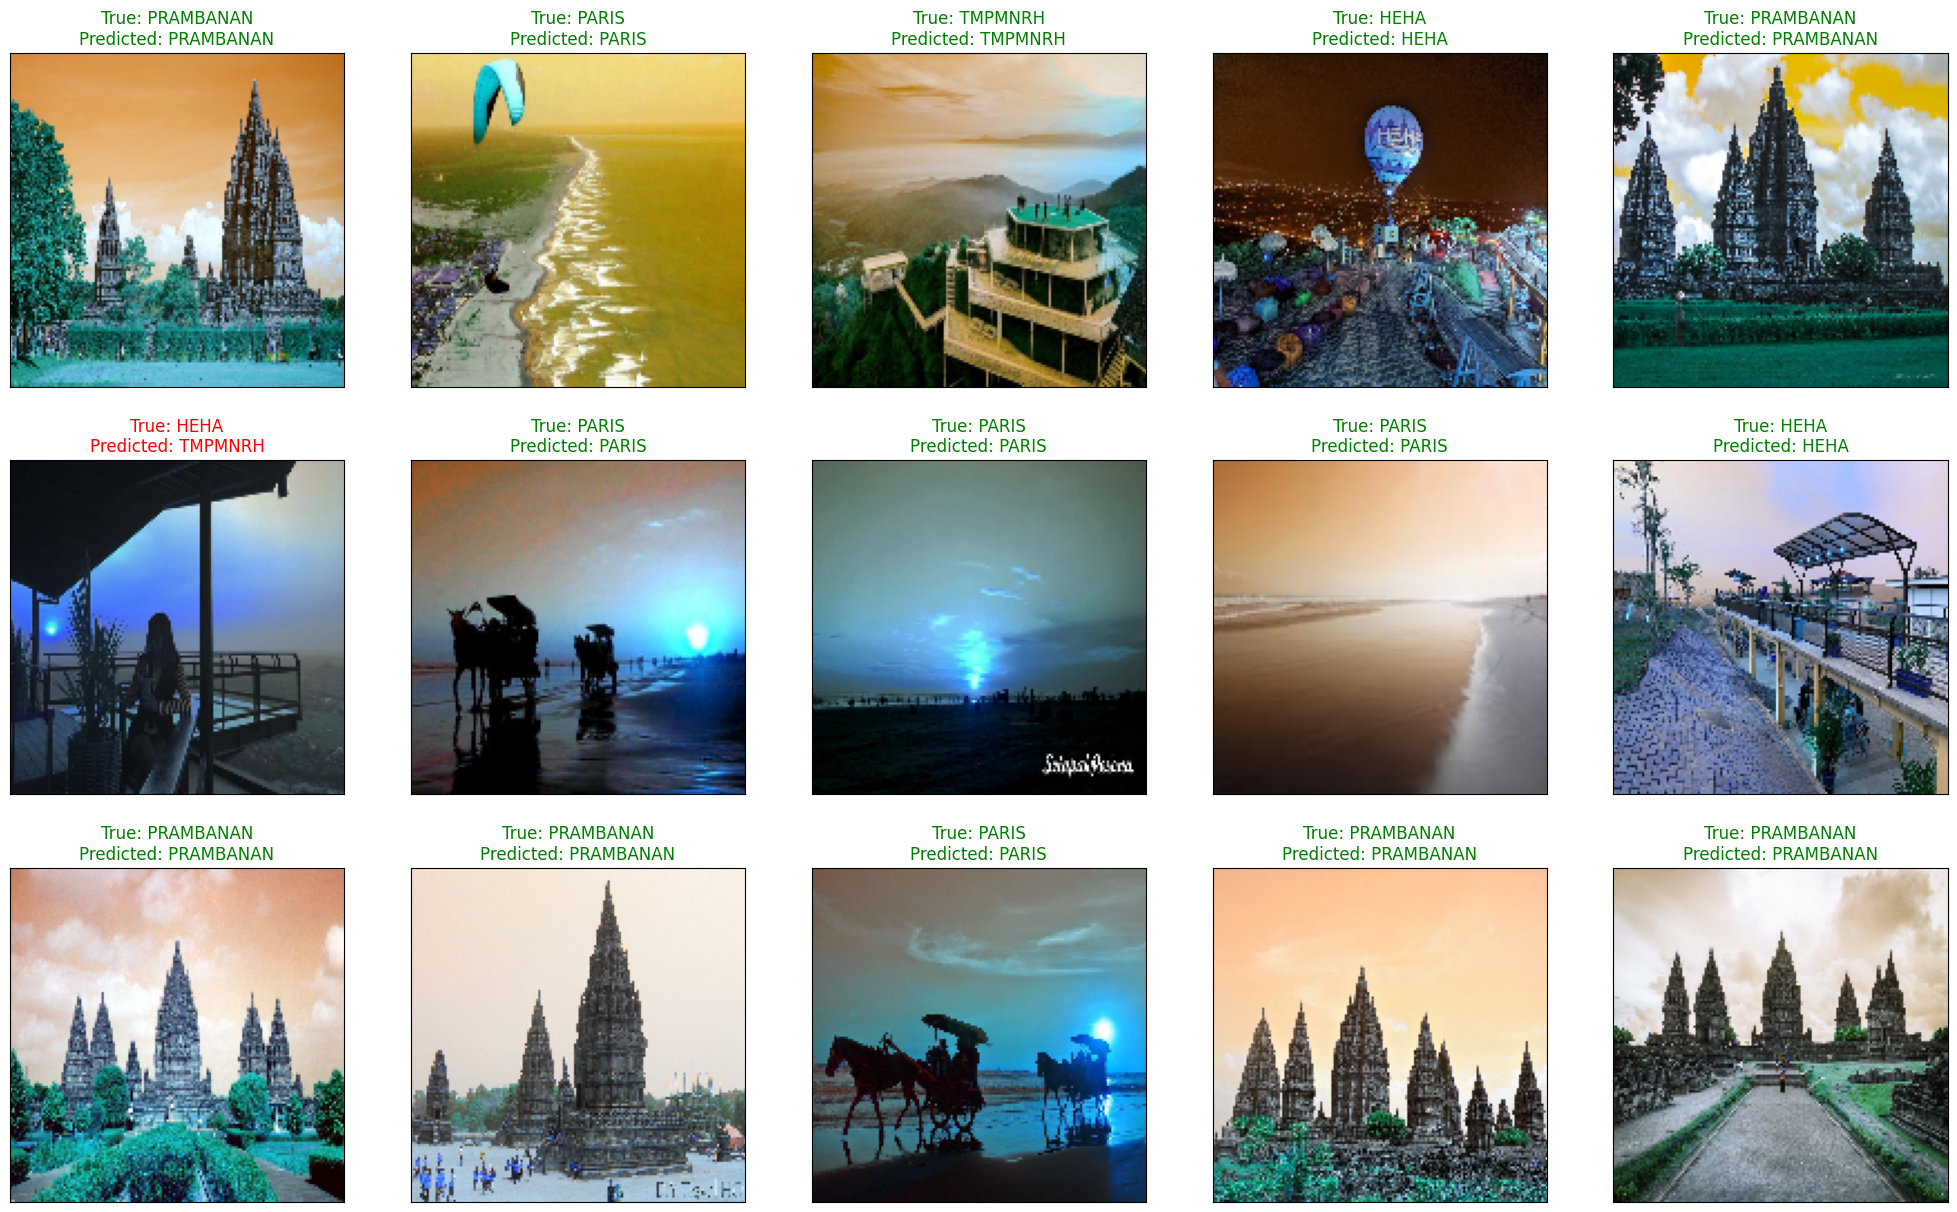

<Figure size 640x480 with 0 Axes>

In [36]:
# Display 15 random pictures from the test set with their labels
random_index = np.random.randint(0, len(x_test) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[random_index[i]])
    if y_true[random_index[i]] == y_pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {le.classes_[y_true[random_index[i]]]}\nPredicted: {le.classes_[y_pred[random_index[i]]]}", color=color)

plt.show()
plt.tight_layout()

In [37]:
#model = tf.keras.models.load_model('saved/model.h5')
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()
#with open('saved/model.tflite', 'wb') as f:
    #f.write(tflite_model)

In [38]:

#import shutil

#directory_to_delete = '/kaggle/working/saved'

# Hapus direktori dan isinya
#shutil.rmtree(directory_to_delete)

#print(f"Direktori {directory_to_delete} berhasil dihapus.")